In [70]:
# import pickle
# import pandas as pd

In [71]:
# file = pickle.load(open('experiments/2024-01-08/pickles/tsfresh_data', 'rb'))
# file

In [72]:
# file.keys()

In [73]:
# file['features_filtered']

In [74]:
# import json

# json_cols = json.load(open('data/kind_fc_params.json')).keys()
# json_cols

In [75]:
# data = file['features_filtered']
# columns = []

# for col in data.columns:    
#     c = col.split('__')[0]

#     if c in columns: continue
    
#     columns.append(c)

In [76]:
# print(columns)

In [77]:
# for col in columns:
#     if col not in json_cols:
#         print(f'\n{col} not in json columns!\n')
#     else:
#         print(f'{col} IN JSON COLS!')

In [78]:
# for col in json_cols:
#     if col not in columns:
#         print(f'\n{col} not in json columns!\n')
#     # else:
#         # print(f'{col} IN JSON COLS!')

In [79]:
# orig_df = pd.read_csv('data/data_2024-01-08.csv')
# orig_df

In [80]:
# orig_df.columns

In [51]:
def _train_ridge(pickle_file, test_start, test_end, z=[1e2, 1e3, 1e4, 1e5], ti=None):
    # save_path = ti['save_path'] 
    
    try:
        file = pickle.load(open(pickle_file, 'rb'))
    except FileExistsError:
        pass
    else:
        features_filtered, y = file['features_filtered'], file['y']
        train, test = features_filtered[features_filtered.index < test_start], features_filtered[(features_filtered.index >= test_start) & (features_filtered.index <= test_end)]

        print(y)
        
        print('Feature filtered:', features_filtered.shape)
        print('Train shape:', train.shape)
        print('Test shape:', test.shape)
        
        results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
        
        scaler = MinMaxScaler().fit(train)
        y_scaler = MinMaxScaler().fit(pd.DataFrame(y[y.index < test.index.min()]))
        
        
        for z_val in z:
            print('Z val:', z_val)
            for date in test.index.tolist():
                date = str(date)[:10]
                
                full_history = features_filtered.copy()
                X_train = full_history[full_history.index < date]
                y_train = y[y.index < date]
                print('Train:', X_train.shape, y_train.shape)
                
                X_test, y_test = full_history[full_history.index >= date], y[y.index >= date][0]
                print('Test:', X_test.shape, y_test.shape)
                
                beta = Ridge(alpha=z_val, solver='svd', fit_intercept=False).fit(X_train, y_train).coef_
                
                forecast = X_test @ beta
                
                results_df = pd.concat([results_df, pd.DataFrame({
                    'pricing_date': [date],
                    'preds': forecast[0],
                    'target': y_test,
                })], ignore_index=True)
                            
                            
            results_df.to_csv(f'tsfresh_virtue_z={z_val}.csv')
            show_plot(results_df, f'tsfresh_virtue_z={z_val}.png')


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

def show_plot(df, save_path, pred='preds'):
    agg_data = df.copy()
    agg_data.pricing_date = pd.to_datetime(agg_data.pricing_date)
    agg_data.forecast_date = agg_data.forecast_date.astype(str)

    agg_data = agg_data.set_index('pricing_date')

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    fig = px.line(df, x=df.index, y=pred, color='forecast_date', markers=True, height=600, width=1200)
    fig.update_traces(opacity=0.5, line=dict(width=2, ))

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    x = df.index
    y = df['target']
    name = 'target'
    fig.add_trace(
        go.Scatter(x=x, y=y, name=name, mode='lines+markers', opacity=0.5, marker=dict(color='darkgray', size=10),
                   line=dict(width=18, color='gray')))  # ,shape = 'hv'
    fig.write_image(save_path)

In [81]:
# import os
# import pickle
# from datetime import datetime

# import numpy as np
# import pandas as pd

# import xgboost as xgb
# from sklearn.preprocessing import MinMaxScaler

# # from data import data
# # from model import model

# import billiard as multiprocessing
# import matplotlib.pyplot as plt
# import tsfresh
# from tsfresh import extract_features, select_features, extract_relevant_features
# from tsfresh.utilities.dataframe_functions import impute

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from sklearn.linear_model import Ridge
# import pickle
# from sklearn.preprocessing import MinMaxScaler

# _train_ridge('experiments/2024-01-09/pickles/tsfresh_data', '2023-01-01', '2023-03-01')

# Working pipeline

In [54]:
data = pd.read_csv('data/data_2024-01-09.csv')
data

,pricing_date,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,...,_rgp_03_sz_3,_rgp_04_sz_3,_rgp_05_sz_3,_rgp_06_sz_3,_rgp_07_sz_3,_rgp_08_sz_3,_rgp_09_sz_3,_rgp_10_sz_3,_rgp_11_sz_3,F380 M2/M3
0,2017-01-10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.50
1,2017-01-11,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.30
2,2017-01-12,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,530.000000,0.000000,920.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.70
3,2017-01-13,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,1060.000000,0.000000,615.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.85
4,2017-01-16,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,1060.000000,0.000000,3.333333,0.0,0.0,0.0,0.000000,0.0,0.0,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,2024-02-02,0.0,0.0,0.0,0.0,0.0,5.000000,0.0,0.0,0.0,...,125.000000,560.888889,0.000000,0.0,0.0,0.0,1114.333333,0.0,0.0,NaN
1844,2024-02-05,0.0,0.0,0.0,0.0,0.0,3.333333,0.0,0.0,0.0,...,-116.666667,386.666667,0.000000,0.0,0.0,0.0,753.333333,0.0,0.0,NaN
1845,2024-02-06,0.0,0.0,0.0,0.0,0.0,3.333333,0.0,0.0,0.0,...,-116.666667,386.666667,0.000000,0.0,0.0,0.0,753.333333,0.0,0.0,NaN
1846,2024-02-07,0.0,0.0,0.0,0.0,0.0,3.333333,0.0,0.0,0.0,...,-116.666667,231.111111,0.000000,0.0,0.0,0.0,753.333333,0.0,0.0,NaN


In [55]:
data.pricing_date = pd.to_datetime(data.pricing_date)
data.set_index('pricing_date', inplace=True)

features, target = data.drop(columns='F380 M2/M3'), data['F380 M2/M3']
features

,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,CAOSG,...,_rgp_02_sz_3,_rgp_03_sz_3,_rgp_04_sz_3,_rgp_05_sz_3,_rgp_06_sz_3,_rgp_07_sz_3,_rgp_08_sz_3,_rgp_09_sz_3,_rgp_10_sz_3,_rgp_11_sz_3
pricing_date,,,,,,,,,,,,,,,,,,,,,
2017-01-10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2017-01-11,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2017-01-12,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,530.000000,0.000000,920.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2017-01-13,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,1060.000000,0.000000,615.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2017-01-16,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,1060.000000,0.000000,3.333333,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02,0.0,0.0,0.0,0.0,0.0,5.000000,0.0,0.0,0.0,0.0,...,-76.083333,125.000000,560.888889,0.000000,0.0,0.0,0.0,1114.333333,0.0,0.0
2024-02-05,0.0,0.0,0.0,0.0,0.0,3.333333,0.0,0.0,0.0,0.0,...,-287.777778,-116.666667,386.666667,0.000000,0.0,0.0,0.0,753.333333,0.0,0.0
2024-02-06,0.0,0.0,0.0,0.0,0.0,3.333333,0.0,0.0,0.0,0.0,...,58.888889,-116.666667,386.666667,0.000000,0.0,0.0,0.0,753.333333,0.0,0.0


In [56]:
test_start, test_end = '2023-01-01', '2024-01-01'

features, target = features[features.index < test_end], target[target.index < test_end]
features.reset_index(inplace=True)

extracted = extract_features(features, column_sort="pricing_date", column_id='pricing_date')

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [15:04<00:00, 30.16s/it]


In [57]:
extracted

,SIETCO__variance_larger_than_standard_deviation,SIETCO__has_duplicate_max,SIETCO__has_duplicate_min,SIETCO__has_duplicate,SIETCO__sum_values,SIETCO__abs_energy,SIETCO__mean_abs_change,SIETCO__mean_change,SIETCO__mean_second_derivative_central,SIETCO__median,...,SELLER1__fourier_entropy__bins_5,SELLER1__fourier_entropy__bins_10,SELLER1__fourier_entropy__bins_100,SELLER1__permutation_entropy__dimension_3__tau_1,SELLER1__permutation_entropy__dimension_4__tau_1,SELLER1__permutation_entropy__dimension_5__tau_1,SELLER1__permutation_entropy__dimension_6__tau_1,SELLER1__permutation_entropy__dimension_7__tau_1,SELLER1__query_similarity_count__query_None__threshold_0.0,SELLER1__mean_n_absolute_max__number_of_maxima_7
2017-01-10,0.0,0.0,0.0,0.0,5.000000,25.000000,NaN,NaN,NaN,5.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,0.0,0.0,0.0,0.0,5.833333,34.027778,NaN,NaN,NaN,5.833333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-12,0.0,0.0,0.0,0.0,5.833333,34.027778,NaN,NaN,NaN,5.833333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-13,0.0,0.0,0.0,0.0,5.000000,25.000000,NaN,NaN,NaN,5.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-16,0.0,0.0,0.0,0.0,2.777778,7.716049,NaN,NaN,NaN,2.777778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,0.0,0.0,0.0,0.0,2.463277,6.067733,NaN,NaN,NaN,2.463277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-26,0.0,0.0,0.0,0.0,1.742471,3.036207,NaN,NaN,NaN,1.742471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-27,0.0,0.0,0.0,0.0,2.340118,5.476152,NaN,NaN,NaN,2.340118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-28,0.0,0.0,0.0,0.0,2.339414,5.472858,NaN,NaN,NaN,2.339414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
impute(extracted)
# y.set_index('pricing_date', inplace=True)
# y['actual_target'] = y['actual_target'].rolling(5).mean()

# extracted = extracted.iloc[5:, :]
# y = y.iloc[5:, :]

# features_filtered = select_features(extracted, target)
# features_filtered

C:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning:

The columns ['SIETCO__mean_abs_change' 'SIETCO__mean_change'
 'SIETCO__mean_second_derivative_central' ...
 'SELLER1__permutation_entropy__dimension_7__tau_1'
 'SELLER1__query_similarity_count__query_None__threshold_0.0'
 'SELLER1__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.



ValueError: Target contains NaN values

In [60]:
target.interpolate(method='linear', inplace=True)

In [61]:
features_filtered = select_features(extracted, target)
features_filtered

,_rgp_01_sz_3__quantile__q_0.9,_rgp_01_sz_3__maximum,"_rgp_01_sz_3__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)",_rgp_01_sz_3__median,"_rgp_01_sz_3__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",_rgp_01_sz_3__sum_values,_rgp_01_sz_3__minimum,"_rgp_01_sz_3__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",_rgp_01_sz_3__quantile__q_0.1,"_rgp_01_sz_3__fft_coefficient__attr_""real""__coeff_0",...,PETCO__maximum,PETCO__root_mean_square,PETCO__absolute_maximum,PETCO__quantile__q_0.1,TRAFI__range_count__max_1__min_-1,TRAFI__count_below__t_0,TRAFI__value_count__value_0,BUYER2__value_count__value_0,BUYER2__range_count__max_1__min_-1,BUYER2__count_below__t_0
2017-01-10,-25.000000,-25.000000,-9.696989,-25.000000,-4.848495,-25.000000,-25.000000,-15.332286,-25.000000,-25.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-01-11,-58.333333,-58.333333,-22.626308,-58.333333,-11.313154,-58.333333,-58.333333,-35.775334,-58.333333,-58.333333,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-01-12,-58.333333,-58.333333,-22.626308,-58.333333,-11.313154,-58.333333,-58.333333,-35.775334,-58.333333,-58.333333,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-01-13,-75.000000,-75.000000,-29.090967,-75.000000,-14.545484,-75.000000,-75.000000,-45.996858,-75.000000,-75.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-01-16,-41.666667,-41.666667,-16.161648,-41.666667,-8.080824,-41.666667,-41.666667,-25.553810,-41.666667,-41.666667,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,-3201.777778,-3201.777778,-1241.904166,-3201.777778,-620.952083,-3201.777778,-3201.777778,-1963.622900,-3201.777778,-3201.777778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2023-12-26,-3432.333333,-3432.333333,-1331.331954,-3432.333333,-665.665977,-3432.333333,-3432.333333,-2105.020649,-3432.333333,-3432.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2023-12-27,-3279.000000,-3279.000000,-1271.857088,-3279.000000,-635.928544,-3279.000000,-3279.000000,-2010.982628,-3279.000000,-3279.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2023-12-28,-4140.904762,-4140.904762,-1606.172331,-4140.904762,-803.086165,-4140.904762,-4140.904762,-2539.581440,-4140.904762,-4140.904762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


# Save features to kind_fc_params.json

In [82]:
import json

kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(features_filtered)

with open('data/kind_fc_params.json', 'w') as fout:
    json.dump(kind_to_fc_parameters, fout)

In [62]:
train = features_filtered[features_filtered.index < test_start]
test  = features_filtered[(features_filtered.index >= test_start) & (features_filtered.index <= test_end)]




In [63]:
z_values = [10**-3, 10**2, 10**3, 10**4,  10**5, 10**6, 10**7, 10**8, 10**9]
backtest = []
y = target

t_values = y[y.index >= test_start].index


for t in t_values:
    test_start = str(t)[:10]
    
    for z in z_values:
        R = y[y.index < test_start]                                         # y_train
        R_s = y[y.index >= test_start]                                      # y_test
        S = features_filtered[features_filtered.index < test_start]         # x_train
        S_t = features_filtered[features_filtered.index >= test_start]      # x_test
        
        T, nr_cols = S.shape
        beta = Ridge(alpha=z, solver='svd', fit_intercept=False).fit(S, R).coef_
        beta_norm = np.sqrt((beta ** 2).sum())
        
        forecast = S_t @ beta
        timing_strategy = forecast * R_s
        
        backtest.append({'z': z, 'beta_norm': beta_norm, 'index': forecast.index[0], 
                        'forecast': forecast.values[0], 'timing_strategy': timing_strategy.values[0],
                        'return': R_s[0]})



In [64]:
backtest

[{'z': 0.001,
  'beta_norm': 29.22253193945854,
  'index': Timestamp('2023-01-02 00:00:00'),
  'forecast': 0.9189903309576969,
  'timing_strategy': 0.45949516547884844,
  'return': 0.5},
 {'z': 100,
  'beta_norm': 2.9628246515982446,
  'index': Timestamp('2023-01-02 00:00:00'),
  'forecast': -0.10739583831056795,
  'timing_strategy': -0.05369791915528398,
  'return': 0.5},
 {'z': 1000,
  'beta_norm': 0.8922108738319056,
  'index': Timestamp('2023-01-02 00:00:00'),
  'forecast': 0.15064149886336592,
  'timing_strategy': 0.07532074943168296,
  'return': 0.5},
 {'z': 10000,
  'beta_norm': 0.29719712101932855,
  'index': Timestamp('2023-01-02 00:00:00'),
  'forecast': 0.43891098271504847,
  'timing_strategy': 0.21945549135752423,
  'return': 0.5},
 {'z': 100000,
  'beta_norm': 0.11306067724271986,
  'index': Timestamp('2023-01-02 00:00:00'),
  'forecast': -0.23760233130014985,
  'timing_strategy': -0.11880116565007492,
  'return': 0.5},
 {'z': 1000000,
  'beta_norm': 0.03591775961536555,
 

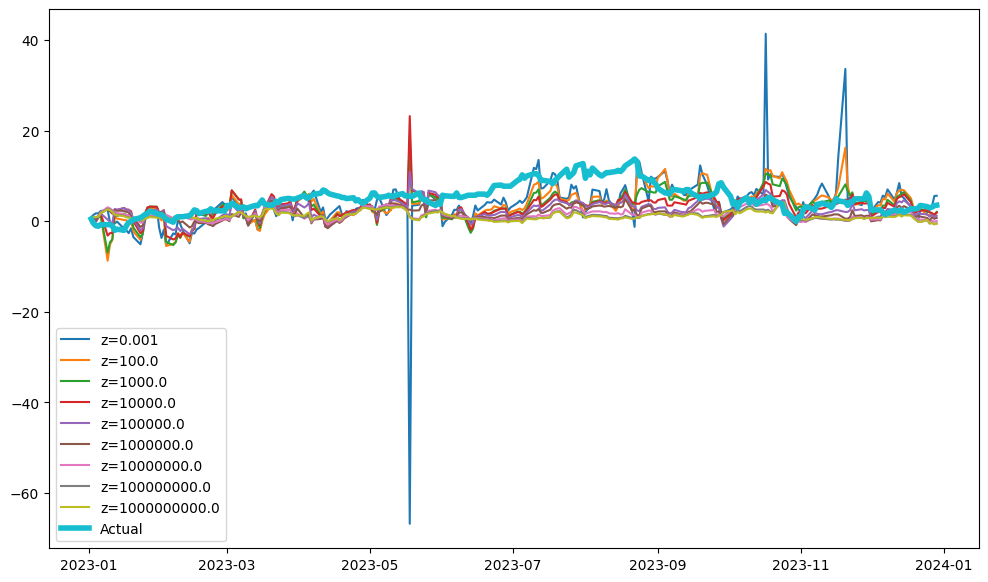

In [65]:
results = pd.DataFrame(backtest)

plt.figure(figsize=(12, 7))

for res in results.groupby('z'):
    idx, r = res
    plt.plot(r['index'], r['forecast'], label=f'z={idx}')

plt.plot(y[y.index > '2023-01-01'], label='Actual', linewidth=4)
plt.legend()
plt.show()

In [66]:
results_df = {}

for res in results.groupby('z'):
    z, r = res
    results_df[str(z)] = r
    
results_df

{'0.001':           z  beta_norm      index  forecast  timing_strategy  return
 0     0.001  29.222532 2023-01-02  0.918990         0.459495   0.500
 10    0.001  29.207880 2023-01-03  1.436237        -0.718118  -0.500
 20    0.001  29.148164 2023-01-04  1.758622        -1.758622  -1.000
 30    0.001  29.092020 2023-01-05  1.727920        -1.900712  -1.100
 40    0.001  29.032339 2023-01-06  2.245748        -1.684311  -0.750
 ...     ...        ...        ...       ...              ...     ...
 2550  0.001  32.909900 2023-12-25  1.910066         6.159963   3.225
 2560  0.001  33.096150 2023-12-26  2.659190         7.844611   2.950
 2570  0.001  33.115546 2023-12-27  3.346006        10.539918   3.150
 2580  0.001  33.108933 2023-12-28  5.586184        19.272336   3.450
 2590  0.001  33.246475 2023-12-29  5.634463        20.002343   3.550
 
 [260 rows x 6 columns],
 '100.0':           z  beta_norm      index  forecast  timing_strategy  return
 1     100.0   2.962825 2023-01-02 -0.107396 

In [67]:
import param
import numpy as np
import panel as pn
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

pn.config.js_files["jquery"]="https://code.jquery.com/jquery-1.12.4.min.js"
pn.config.js_files["sparkline"]="https://cdnjs.cloudflare.com/ajax/libs/jquery-sparklines/2.1.2/jquery.sparkline.min.js"

pn.extension('tabulator', 'plotly', 'ipywidgets', 'perspective',  css_files=[pn.io.resources.CSS_URLS['font-awesome']], sizing_mode='stretch_width', omms='ipywidgets')

pn.config.js_files["sparkline_to_tabulator"]="https://cdn.jsdelivr.net/gh/MarcSkovMadsen/awesome-panel-assets@master/js/add_spark_lines_to_tabulator.min.js"



In [68]:
RESULTS = None

checkboxes = pn.widgets.CheckBoxGroup(name='Checkbox Group', value=['0.001'], options=list(results_df.keys()), inline=False, margin=(20, 10, 10, 10))

def custom_pnl_10(y_pred, y_true):
    nth = len(y_pred)
    y_pred, y_true = list(y_pred.values), list(y_true.values)

    thresh = 0.2
    
    try:
        diff = y_pred[-1] - y_pred[0]
    except IndexError:
        diff = y_pred[-1] - y_pred[0]

    direction = 1 if diff > thresh else (-1 if diff < thresh else 0)
    pnl = diff * direction

    return 'pnl', pnl


def create_pnl(df_copy):
    results = {}
    
    if RESULTS is not None:
        for z in RESULTS.keys():
            results[z] = custom_pnl_10(RESULTS[z]['preds'], RESULTS[z]['target'])[1]

        return pd.DataFrame(results.values(), index=results.keys(), columns=['pnl'])

    return pd.DataFrame()


@pn.depends(checkboxes.param.value)
def update_pnl_df(sel):
    if RESULTS is not None:
        return create_pnl(RESULTS)
    
    
    
    
    return create_pnl(RESULTS)

In [69]:

@pn.depends(checkboxes.param.value)
def update_plot(selected):
    global RESULTS
    
    RESULTS = {}
    
    sel = [results_df.get(key) for key in selected]

    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=y[y.index > '2023-01-01'].index, y=y[y.index > '2023-01-01'], name=f'Actual', connectgaps=False))
    
    for unique in sel:
        print('UNIQUE', unique)
        fig.add_trace(go.Scatter(x=unique['index'], y=unique['forecast'], name=f'z={unique.z.unique()[0]}', connectgaps=False))

        RESULTS[unique.z.unique()[0]] = {'preds': unique['forecast'], 'target': y[y.index > '2023-01-01']}

    return fig


pn.Column(checkboxes, update_plot, update_pnl_df).show()

UNIQUE           z  beta_norm      index  forecast  timing_strategy  return
0     0.001  29.222532 2023-01-02  0.918990         0.459495   0.500
10    0.001  29.207880 2023-01-03  1.436237        -0.718118  -0.500
20    0.001  29.148164 2023-01-04  1.758622        -1.758622  -1.000
30    0.001  29.092020 2023-01-05  1.727920        -1.900712  -1.100
40    0.001  29.032339 2023-01-06  2.245748        -1.684311  -0.750
...     ...        ...        ...       ...              ...     ...
2550  0.001  32.909900 2023-12-25  1.910066         6.159963   3.225
2560  0.001  33.096150 2023-12-26  2.659190         7.844611   2.950
2570  0.001  33.115546 2023-12-27  3.346006        10.539918   3.150
2580  0.001  33.108933 2023-12-28  5.586184        19.272336   3.450
2590  0.001  33.246475 2023-12-29  5.634463        20.002343   3.550

[260 rows x 6 columns]
Launching server at http://localhost:59506


UNIQUE           z  beta_norm      index  forecast  timing_strategy  return
0     0.001  29.222532 2023-01-02  0.918990         0.459495   0.500
10    0.001  29.207880 2023-01-03  1.436237        -0.718118  -0.500
20    0.001  29.148164 2023-01-04  1.758622        -1.758622  -1.000
30    0.001  29.092020 2023-01-05  1.727920        -1.900712  -1.100
40    0.001  29.032339 2023-01-06  2.245748        -1.684311  -0.750
...     ...        ...        ...       ...              ...     ...
2550  0.001  32.909900 2023-12-25  1.910066         6.159963   3.225
2560  0.001  33.096150 2023-12-26  2.659190         7.844611   2.950
2570  0.001  33.115546 2023-12-27  3.346006        10.539918   3.150
2580  0.001  33.108933 2023-12-28  5.586184        19.272336   3.450
2590  0.001  33.246475 2023-12-29  5.634463        20.002343   3.550

[260 rows x 6 columns]
UNIQUE            z  beta_norm      index  forecast  timing_strategy  return
2     1000.0   0.892211 2023-01-02  0.150641         0.075321   

# Check columns

In [84]:
file = pickle.load(open('experiments/2024-01-10/pickles/tsfresh_data', 'rb'))
features_filtered, target = file['features_filtered'], file['y']

In [86]:
test_start = '2023-01-01'
z_values = [10**4]

In [88]:
backtest = []
y = target

results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])

t_values = y[y.index >= test_start].index

for t in t_values:
    test_start = str(t)[:10]
    
    for z in z_values:
        R = y[y.index < test_start]                                         # y_train
        R_s = y[y.index >= test_start]                                      # y_test
        S = features_filtered[features_filtered.index < test_start]         # x_train
        S_t = features_filtered[features_filtered.index >= test_start]      # x_test
        
        T, nr_cols = S.shape
        beta = Ridge(alpha=z, solver='svd', fit_intercept=False).fit(S, R).coef_
        beta_norm = np.sqrt((beta ** 2).sum())
        
        forecast = S_t @ beta
        timing_strategy = forecast * R_s

        results_df = pd.concat([results_df, pd.DataFrame({
            'pricing_date': [test_start],
            'preds': [forecast.values[0]],
            'target': [R_s.values[0]],
        })], ignore_index=True)
                    
        results_df.to_excel(os.path.join(f'tsfresh_virtue_z={z}.xlsx'), sheet_name=f'z={z}')
        show_plot(results_df, f'z={z}.png')